In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    TrainerCallback,
    Trainer,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Configuration settings
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
NUM_EPOCHS = 5
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MODEL_NAME = "roberta-base"
RANDOM_SEED = 42
CLASS_NAMES = ["World", "Sports", "Business", "Sci/Tech"]



In [3]:
# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess AG News dataset
print("Loading and preprocessing the AG News dataset...")
dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

# Tokenize datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Using device: cuda
Loading and preprocessing the AG News dataset...


In [4]:

# Split training data into train and validation
tokenized_dataset["train"] = tokenized_dataset["train"].shuffle(seed=RANDOM_SEED)
train_size = int(0.9 * len(tokenized_dataset["train"]))
train_dataset = tokenized_dataset["train"].select(range(train_size))
val_dataset = tokenized_dataset["train"].select(range(train_size, len(tokenized_dataset["train"])))

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(tokenized_dataset['test'])}")

# Load model
print(f"Loading {MODEL_NAME} model...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,
    problem_type="single_label_classification"
)

# Calculate baseline parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\n======= MODEL PARAMETERS =======")
print(f"Total parameters in base model: {total_params:,}")


Train size: 108000, Validation size: 12000, Test size: 7600
Loading roberta-base model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======= MODEL PARAMETERS =======
Total parameters in base model: 124,648,708


In [5]:

# Configure LoRA
print("Configuring LoRA adapters...")
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=["query"],
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_CLS
)


# Apply LoRA adapters
model = get_peft_model(model, lora_config)
model.to(device)

# Calculate trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters with LoRA: {trainable_params:,}")
print(f"Parameter efficiency: {trainable_params/total_params*100:.2f}%")
print(f"Parameter reduction: {(total_params-trainable_params)/total_params*100:.2f}%")
print("================================\n")



Configuring LoRA adapters...
Trainable parameters with LoRA: 888,580
Parameter efficiency: 0.71%
Parameter reduction: 99.29%



In [6]:
# Custom callback to capture training history
class MetricsCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.training_loss = []
        self.eval_loss = []
        self.eval_accuracy = []
        self.eval_f1 = []

    # Override on_init_end method to accept any arguments
    def on_init_end(self, args, state, control, **kwargs):
        pass

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs and 'eval_loss' not in logs:
                self.training_loss.append((state.global_step, logs['loss']))
            if 'eval_loss' in logs:
                self.eval_loss.append((state.global_step, logs['eval_loss']))
                self.eval_accuracy.append((state.global_step, logs['eval_accuracy']))
                self.eval_f1.append((state.global_step, logs['eval_f1']))


# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate various metrics
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')

    return {
        "accuracy": acc,
        "f1": f1
    }


In [7]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    warmup_ratio=WARMUP_RATIO,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",
    save_total_limit=2
)



In [8]:
# Initialize metrics callback
metrics_callback = MetricsCallback()

# Set up trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2), metrics_callback]
)




/tmp/ipykernel_5294/1317770248.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [9]:
# Train the model
print("Starting training...")
train_result = trainer.train()

# Print training summary
print("\n======= TRAINING SUMMARY =======")
print(f"Total training steps: {train_result.global_step}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")
print("================================\n")



Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.236000,0.210532,0.931000,0.931137
2,0.205000,0.184090,0.937500,0.937709
3,0.178800,0.172217,0.941083,0.941310
4,0.179100,0.168236,0.941417,0.941505
5,0.155200,0.165209,0.943583,0.943720



======= TRAINING SUMMARY =======
Total training steps: 16875
Training time: 2524.65 seconds
Training samples/second: 213.89
Final training loss: 0.2169



In [10]:
# Evaluate on test set
print("\nEvaluating on test set...")
eval_results = trainer.evaluate(tokenized_dataset["test"])
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Test F1 Score: {eval_results['eval_f1']:.4f}")

# Get detailed classification report
test_pred = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(test_pred.predictions, axis=-1)
labels = test_pred.label_ids

print("\n======= CLASSIFICATION REPORT =======")
print(classification_report(labels, preds, target_names=CLASS_NAMES))
print("=====================================\n")




Evaluating on test set...


Test Accuracy: 0.9409
Test F1 Score: 0.9409

======= CLASSIFICATION REPORT =======
              precision    recall  f1-score   support

       World       0.95      0.95      0.95      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.92      0.90      0.91      1900
    Sci/Tech       0.91      0.92      0.92      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600




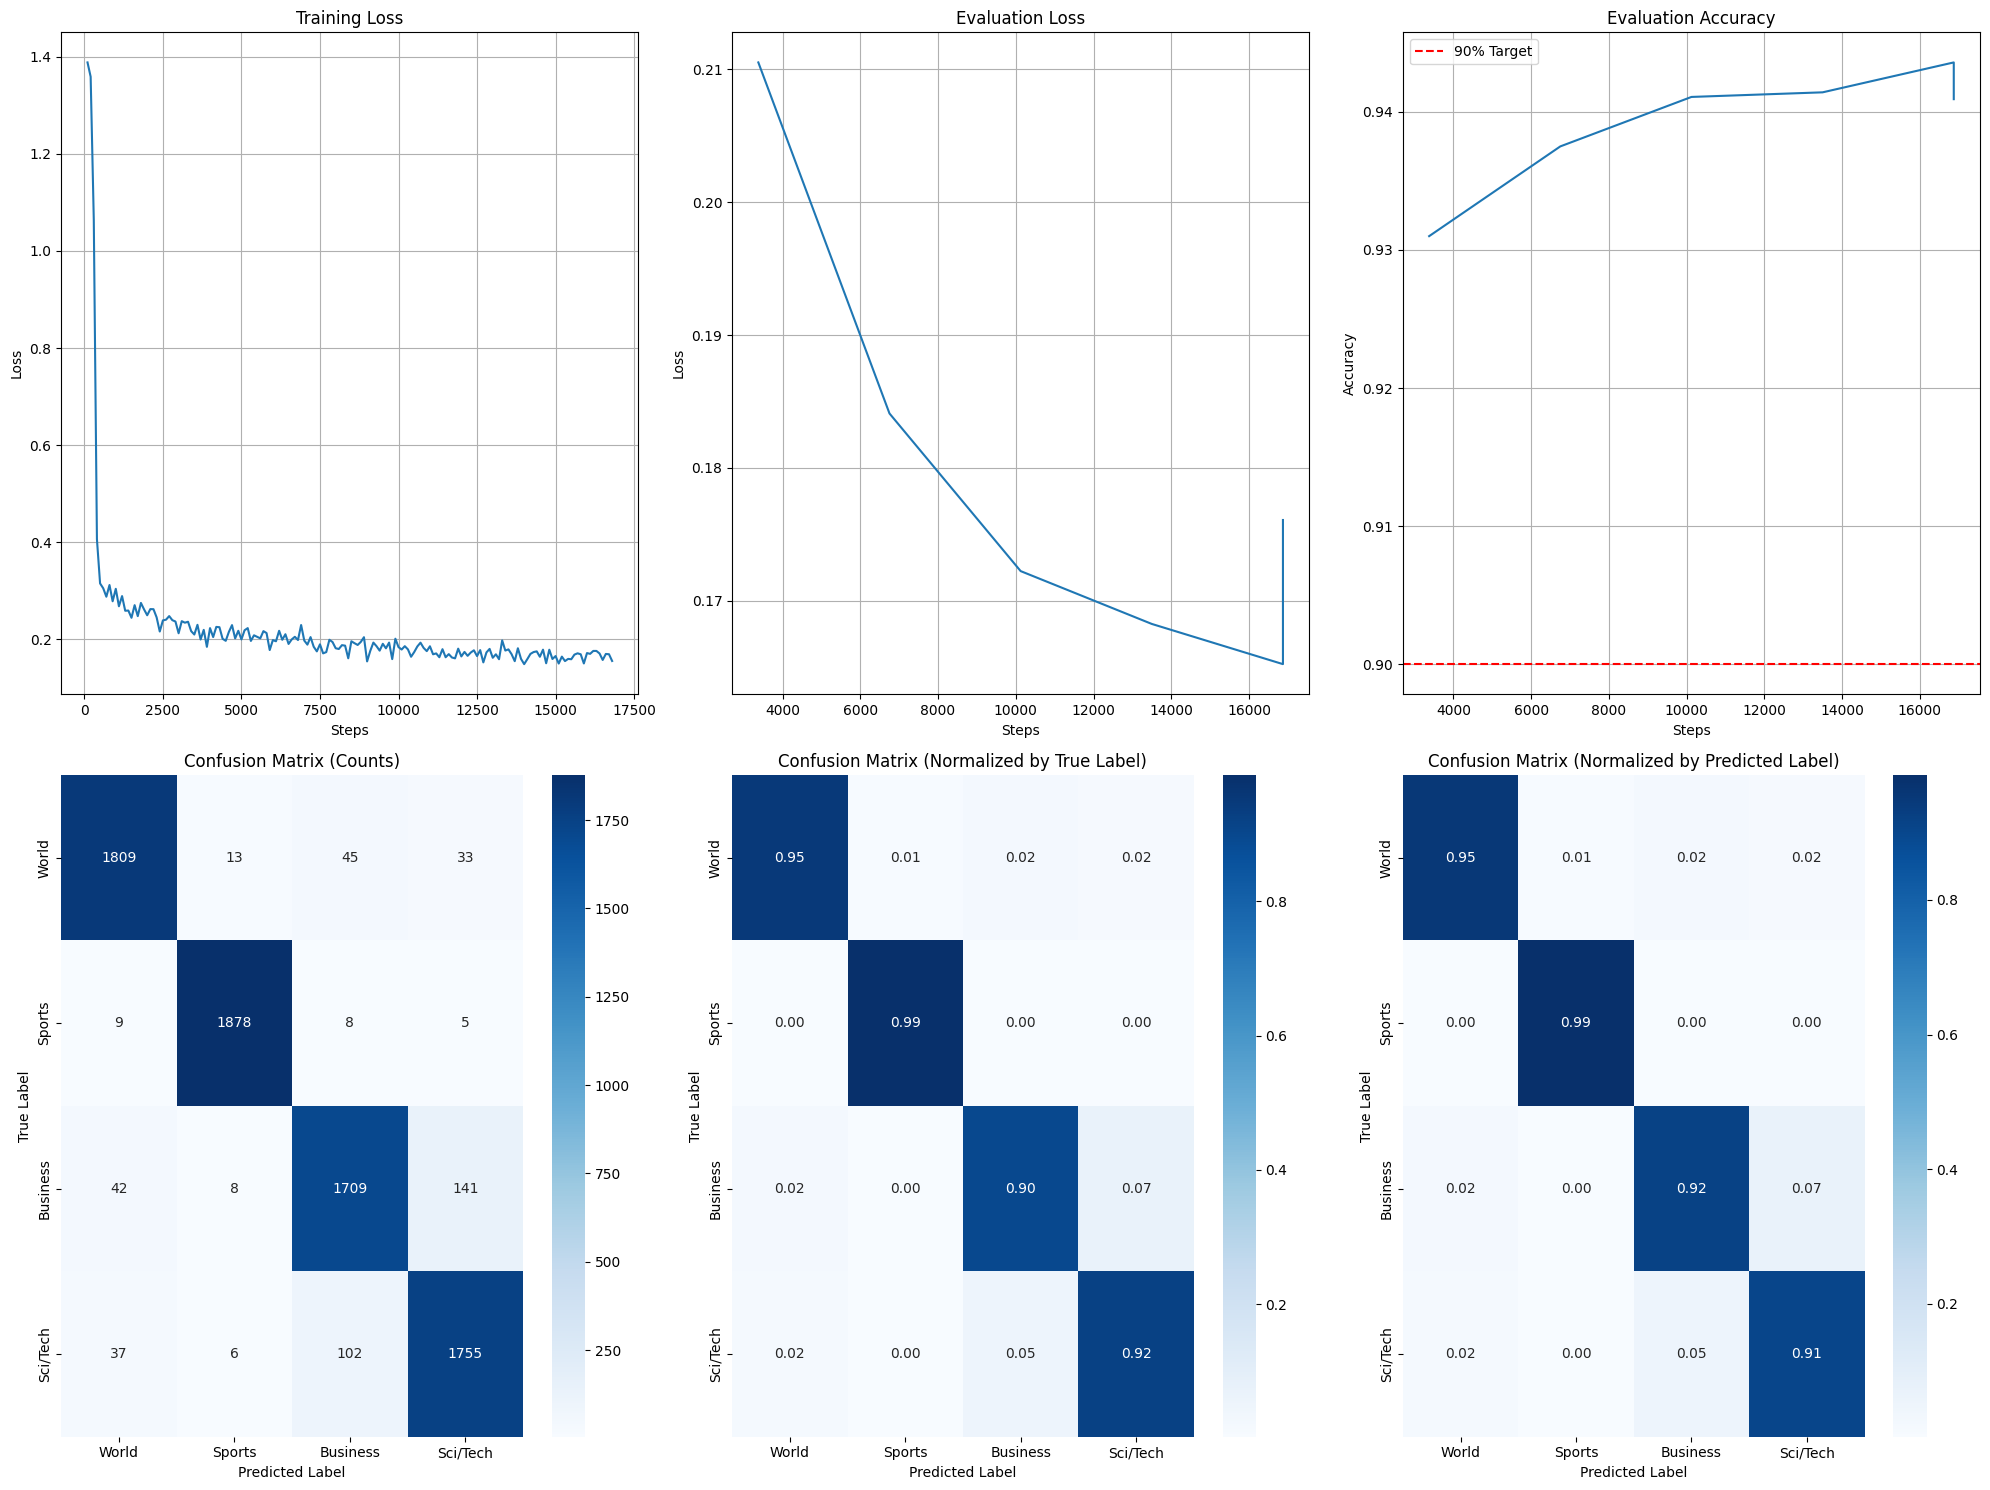


======= PER-CLASS ANALYSIS =======
      Class  Precision    Recall  F1-Score  Support
0     World   0.953611  0.952105  0.952858   1900.0
1    Sports   0.985827  0.988421  0.987122   1900.0
2  Business   0.916845  0.899474  0.908077   1900.0
3  Sci/Tech   0.907446  0.923684  0.915493   1900.0


<Figure size 1000x600 with 0 Axes>

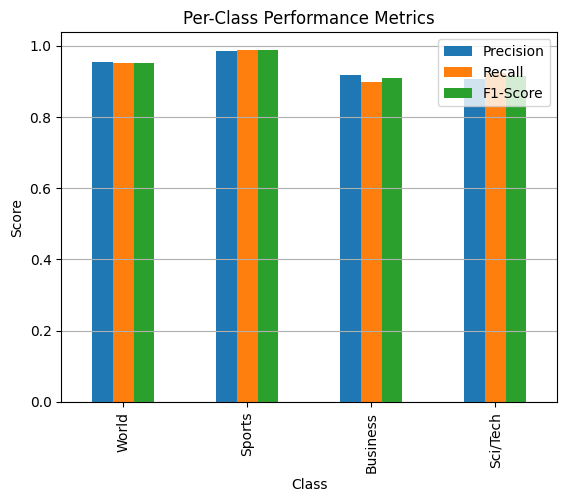

In [11]:
# Create figure for all plots
plt.figure(figsize=(20, 15))

# Plot 1: Training Loss
plt.subplot(2, 3, 1)
train_steps, train_loss = zip(*metrics_callback.training_loss)
plt.plot(train_steps, train_loss)
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)

# Plot 2: Evaluation Loss
plt.subplot(2, 3, 2)
if metrics_callback.eval_loss:
    eval_steps, eval_loss = zip(*metrics_callback.eval_loss)
    plt.plot(eval_steps, eval_loss)
    plt.title('Evaluation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.grid(True)

# Plot 3: Evaluation Accuracy
plt.subplot(2, 3, 3)
if metrics_callback.eval_accuracy:
    eval_steps, eval_acc = zip(*metrics_callback.eval_accuracy)
    plt.plot(eval_steps, eval_acc)
    plt.title('Evaluation Accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Add horizontal line at 90% accuracy
    plt.axhline(y=0.9, color='r', linestyle='--', label='90% Target')
    plt.legend()

# Compute and plot confusion matrix - Absolute counts
plt.subplot(2, 3, 4)
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized confusion matrix by row (true labels)
plt.subplot(2, 3, 5)
cm_norm_true = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm_true, annot=True, fmt='.2f', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix (Normalized by True Label)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized confusion matrix by column (predicted labels)
plt.subplot(2, 3, 6)
cm_norm_pred = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
sns.heatmap(cm_norm_pred, annot=True, fmt='.2f', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix (Normalized by Predicted Label)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('training_and_confusion_matrix.png', dpi=300)
plt.show()

# Additional per-class analysis
print("\n======= PER-CLASS ANALYSIS =======")
class_report = classification_report(labels, preds, target_names=CLASS_NAMES, output_dict=True)
class_metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': [class_report[cls]['precision'] for cls in CLASS_NAMES],
    'Recall': [class_report[cls]['recall'] for cls in CLASS_NAMES],
    'F1-Score': [class_report[cls]['f1-score'] for cls in CLASS_NAMES],
    'Support': [class_report[cls]['support'] for cls in CLASS_NAMES]
})
print(class_metrics_df)

# Plot per-class metrics
plt.figure(figsize=(10, 6))
class_metrics_df_plot = class_metrics_df.set_index('Class')
class_metrics_df_plot[['Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.title('Per-Class Performance Metrics')
plt.ylabel('Score')
plt.grid(axis='y')
plt.savefig('per_class_metrics.png', dpi=300)
plt.show()



In [12]:
import os
import pickle
from datasets import Dataset
from torch.utils.data import DataLoader

# Tokenization function for processing the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Parameters
BATCH_SIZE = 8  # Adjust this based on your needs
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # Use the tokenizer you are using
# Assuming the user wants to use the same tokenizer as for training:
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Processing the competition test set
print("\nLoading and processing test set...")
test_dataset = None  # Initialize test_dataset to None

# Specify the correct path to your test_unlabelled.pkl file
test_file_path = "test_unlabelled.pkl"  # Replace with the actual path

# Load the test dataset
try:
    with open(test_file_path, "rb") as f:
        test_dataset = pickle.load(f)
except FileNotFoundError:
    raise FileNotFoundError(f"test_unlabelled.pkl not found at the specified path: {test_file_path}")

# Convert to HuggingFace Dataset
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

# Tokenize test data
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create DataLoader for batched inference
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=BATCH_SIZE * 2)

print("\nTest dataset processed and ready for inference.")


Loading and processing test set...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]


Test dataset processed and ready for inference.


In [13]:
# Save the model and tokenizer
trainer.model.save_pretrained("\result")
tokenizer.save_pretrained("\result")
# Save the model
trainer.save_model("\result")


In [14]:
# Run predictions
print("Generating predictions on test set...")
model.eval()
all_predictions = []
all_confidences = []  # Track prediction confidences

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits

        # Get predicted class
        preds = torch.argmax(logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())

        # Get confidence scores (softmax probabilities)
        probs = torch.nn.functional.softmax(logits, dim=1)
        confidences = torch.max(probs, dim=1)[0]
        all_confidences.extend(confidences.cpu().numpy())

# Add confidence scores to output dataframe
submission_df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),
    "Label": all_predictions,
    "Confidence": all_confidences
})



Generating predictions on test set...


In [15]:
# Save predictions to CSV in the required format (without confidence)
final_submission_df = submission_df[["ID", "Label"]]
submission_file = "submission.csv"
final_submission_df.to_csv(submission_file, index=False)

# Also save a version with confidence scores for analysis
submission_with_confidence = "submission_with_confidence.csv"
submission_df.to_csv(submission_with_confidence, index=False)



✅ Predictions complete. Saved to submission.csv
Submission file shape: (8000, 2)
   ID  Label
0   0      3
1   1      0
2   2      0
3   3      3
4   4      1


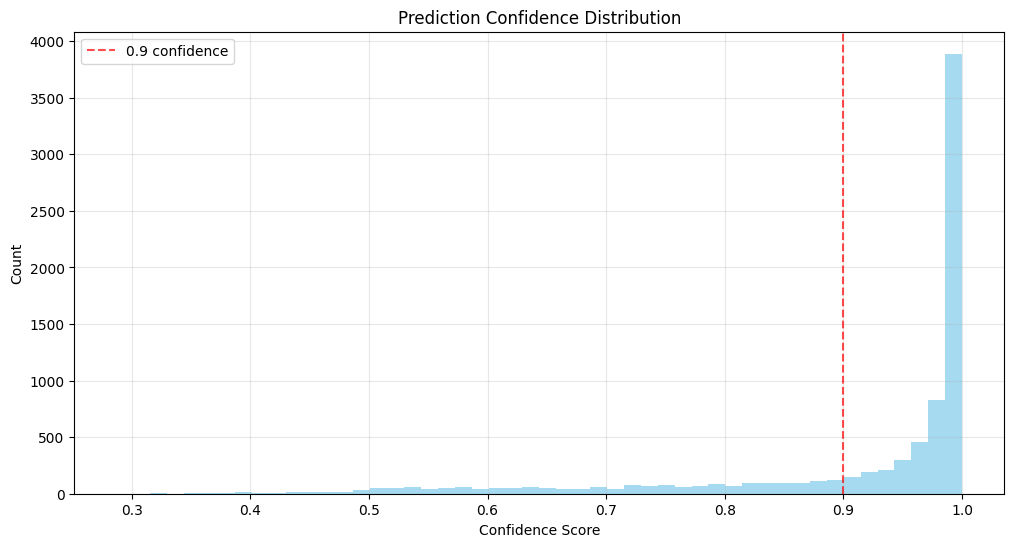


======= PREDICTION CONFIDENCE =======
Mean confidence: 0.9162
Median confidence: 0.9842
Min confidence: 0.2873
Max confidence: 1.0000
Predictions with confidence > 0.9: 75.24%



In [16]:
print(f"✅ Predictions complete. Saved to {submission_file}")
print(f"Submission file shape: {final_submission_df.shape}")
print(final_submission_df.head())

# Plot confidence distribution
plt.figure(figsize=(12, 6))
plt.hist(all_confidences, bins=50, alpha=0.75, color='skyblue')
plt.axvline(x=0.9, color='red', linestyle='--', alpha=0.7, label='0.9 confidence')
plt.grid(True, alpha=0.3)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.legend()
plt.savefig('confidence_distribution.png', dpi=300)
plt.show()

# Print confidence statistics
print("\n======= PREDICTION CONFIDENCE =======")
print(f"Mean confidence: {np.mean(all_confidences):.4f}")
print(f"Median confidence: {np.median(all_confidences):.4f}")
print(f"Min confidence: {np.min(all_confidences):.4f}")
print(f"Max confidence: {np.max(all_confidences):.4f}")
print(f"Predictions with confidence > 0.9: {np.sum(np.array(all_confidences) > 0.9) / len(all_confidences):.2%}")
print("=====================================\n")



In [17]:
# Save parameter and accuracy summary
summary = {
    "Total Parameters": total_params,
    "Trainable Parameters": trainable_params,
    "Parameter Efficiency": f"{trainable_params/total_params*100:.4f}%",
    "Final Training Loss": train_result.metrics['train_loss'],
    "Test Accuracy": eval_results['eval_accuracy'],
    "Test F1 Score": eval_results['eval_f1'],
    "Mean Prediction Confidence": f"{np.mean(all_confidences):.4f}"
}

# Save summary to file
with open('model_summary.txt', 'w') as f:
    f.write("======= MODEL SUMMARY =======\n")
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")
    f.write("============================\n")

print("\n======= MODEL SUMMARY =======")
for key, value in summary.items():
    print(f"{key}: {value}")
print("============================")


======= MODEL SUMMARY =======
Total Parameters: 124648708
Trainable Parameters: 888580
Parameter Efficiency: 0.7129%
Final Training Loss: 0.2169390232792607
Test Accuracy: 0.940921052631579
Test F1 Score: 0.9408872997021228
Mean Prediction Confidence: 0.9162
